## Programming exercise 1: Score distribution
### Goals:
1. All POIs should end up with a score between 0 and 10.
2. There should be significantly more POIs with score between k-1 and k than between k and k+1 for all k in [1..9].
3. Very few POIs should end up with a score between 9 and 10.  Such high scores should really only go to the very best POIs in the world: aim to have about 0.1%-0.2% of POIs in this range.
4. The algorithm should work regardless of the range and distribution of the input scores.

--> I refer to these goals in the comments as **[GOAL1], [GOAL2], [GOAL3], [GOAL4].**

### Approach
This Notebook is divided in two parts:
* Part 1) I perform a short analysis of the first data set (section a) and third data set (section b) listing the steps necessary for the re-scoring. I use the Zipf power law function as suggested, presenting the results and making an assessment of how well they satisfy the required GOALS.

* Part 2) The approach is very similar to the one in Part 1. The only different is that I use here a different Power funcion and apply it to the remaining data set (second one), also here I explain how well the [GOALS] are met.

### Obs: 
- I decided not to define general functions for repetitive steps and leave these in a more "scripting way" - of course the data ingestion, pre-processing and re-scoring could be encapsulated in functions for re-use. 
- Even though in the description of the excersice you require to preserve the relative order of the POI scores ONLY for the part 1, I decided to do it for both (when possible - as the second data set has duplicate POI ids)

### Libraries used
I decided to use pandas dataframes to store the data sets and manipulate them. Numpy was used for some basic functions and also for calling the Zipf (**numpy.random.zipf**) & Power (**numpy.random.power**) functions. Also matplotlip was used for some data plotting.

In [22]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Importing data

In [23]:
#data is imported into pandas data frames
df1 = pd.read_csv('raw_scores.list1', delimiter=' ', header=None)
df2 = pd.read_csv('raw_scores.list2', delimiter=' ', header=None)
df3 = pd.read_csv('raw_scores.list3', delimiter=' ', header=None)
# add labels to the columns
df1.columns = ['id', 'score']
df2.columns = ['id', 'score']
df3.columns = ['id', 'score']

## PART 1 (a) - First data set [Zipf Function]

####  DATA PRE-ANALYSIS:
The first data set has unique POI ids and a few duplicate scores (which is fine). Indeed the scores are very low, which can be observed by checking the percentiles (25,50,75).

I also plotted a histogram of the original data distribution among the 10 categories - we can see that most of the ranks for this data set are between 2 and 3, which is not in conformity with [GOAL2]

To easen the analysis I sorted the original dataframe by descending scores. 

In [687]:
# Uniqueness test 'ids': All 'POI ids' are unique 
df1['id'].value_counts()

T__c559a21c8b9a    1
T__c937e1b0612d    1
T__3a67884aaa71    1
T__c97b0676d7e6    1
T__e9588720a635    1
                  ..
T__979ccab4fb17    1
T__ca2777747600    1
T__e969b326aefb    1
T__ed1d12fc9b33    1
T__5b8ee000ec7b    1
Name: id, Length: 91897, dtype: int64

In [688]:
# Uniqueness test 'score': not all scores are unique --> 12 scores 91897 are repeated.
df1['score'].value_counts()

4.659384    2
4.104999    2
2.183322    2
1.934045    2
0.235774    2
           ..
3.220971    1
1.429778    1
1.202740    1
2.692523    1
1.141867    1
Name: score, Length: 91885, dtype: int64

In [689]:
# basic statistical info of the distribution
df1.describe()

,score
count,91897.000000
mean,2.666456
std,1.254700
min,0.075584
25%,1.697081
50%,2.716161
75%,3.430307
max,9.978895


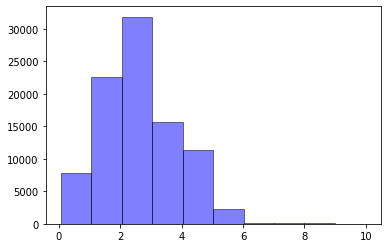

In [690]:
#histogram of origianl score distribution among the 10 categories
x = df1['score']
num_bins = 10
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5, ec='black')
plt.show()

In [691]:
# Sorting the original dataframe by descending scores. 
df1_sorted = df1.sort_values(by=['score', 'id'], ascending=False)

####  RE-SCORING:
As suggested by you I decided to create Zipfian (Zipf) distribution. The function generates a random Zipfian distribution and will be, therefore different everytime it is called. The distribution parameter (a) is expected to be greater than 1. Empirism shows that, for higher a values, the drop in the scores is very fast.
I decided for using the following values for test purposes and checked how many POIs were between [9-10] by using the NEW SCORES ALONE: 

1) a = 2:    ~ 0,0011% of the POI ids having scores within 9-10 (much lower than [GOAL3])<br>
2) a = 1.1:  ~ 0.13% of the POI ids having scores within 9-10 (satisfies [GOAL3])<br>
3) a = 1.01: ~ 0.43% of the POI ids having scores within 9-10 (too high - exceeds [GOAL3])

Since we need to garantee that about 0.1%-0.2%, I would go for a = 1.1

In [692]:
a = 1.1
zipf_dist = np.random.zipf(a,df1.shape[0])

In [693]:
#sort Zipf distribution  
zipf_dist[::-1].sort()

#normalize values between 0-10 to fulfill [GOAL1]
zipf_dist_norm = ((zipf_dist-min(zipf_dist))/(max(zipf_dist)-min(zipf_dist))) * 10

# add normalized scores as a new column to the dataframe - by adding the sorted distribution to the already 
# sorted dataframe, we guarantee that the relative order of the POI scores is preserved.
df1_sorted['zipf score'] = zipf_dist_norm

For long lists of values, the Zipf power law leeds to an extremely bottom-heavy distribution, ending with many values equal to the minimum - This not only cause that many values are repeated, but also does not comply with the requirement that the 
 relative order of POI ids should be preserved - therefore I mixed the original scores with the Zipf scores
by creating a new score (mix score). These are calculated by the weighted average of the original and Zipf scores.

In [694]:
# I found empirically that weights of 90% and 10% respectively would provide the achievement of [GOAL2] & [GOAL3]
weight_zipf = 0.9
weight_orig = 0.1
mix_score = df1_sorted['score']*weight_orig + df1_sorted['zipf score']*weight_zipf
df1_sorted['mix score'] = np.where(df1_sorted['score'] > 10, 10, mix_score)

In [695]:
df1_sorted.head(10)

,id,score,zipf score,mix score
12270,T__090ce1e666ea,9.978895,10.000000,9.997889
48377,T__2174d75627c1,9.919893,9.981566,9.975398
21746,T__85442a13f9b1,9.741483,9.963294,9.941113
28623,T__4e2dc10ba3e0,9.725527,9.949366,9.926982
78151,T__a50467a12849,9.658986,9.936527,9.908773
17165,T__08161a7d68cf,9.638736,9.916676,9.888882
2846,T__a6a9d3987005,9.564022,9.874857,9.843774
23843,T__064a9f565efc,9.482713,9.870646,9.831853
73290,T__450bc550c54e,9.468666,9.864531,9.824944
66813,T__7346d3b3c938,9.454223,9.850477,9.810852


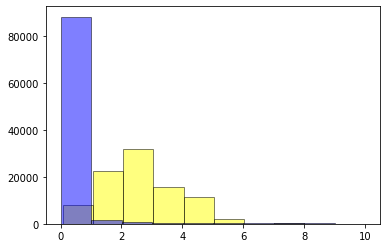

In [696]:
#histogram of the Zipf score distribution among the 10 categories
x = df1['score']
num_bins = 10
plt.hist(x, num_bins, facecolor='yellow', alpha=0.5, ec='black')

x = df1_sorted['mix score']
num_bins = 10
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5, ec='black')
plt.show()

In [697]:
# number of elements within each score interval: We can see it drops after each interval. However, the drop between [0-1] and
# [1-2] is much more dramatic than between other intervals. This leeds to an extremely bottom-heavy distribution.
# In my opinion it only satisfies [GOAL2] partially - I would prefer a smoothier distribution from 0 to 10 

print(n)

[88194.  1451.   662.   392.   340.   254.   188.   163.   136.   117.]


In [698]:
#percentage of elements with scores between 9 and 10: ~ 0.12% [GOAL3] is satisfied!
n[-1]/df1.shape[0]*100

0.12731645211486775

In [699]:
df1_sorted.head(10)

,id,score,zipf score,mix score
12270,T__090ce1e666ea,9.978895,10.000000,9.997889
48377,T__2174d75627c1,9.919893,9.981566,9.975398
21746,T__85442a13f9b1,9.741483,9.963294,9.941113
28623,T__4e2dc10ba3e0,9.725527,9.949366,9.926982
78151,T__a50467a12849,9.658986,9.936527,9.908773
17165,T__08161a7d68cf,9.638736,9.916676,9.888882
2846,T__a6a9d3987005,9.564022,9.874857,9.843774
23843,T__064a9f565efc,9.482713,9.870646,9.831853
73290,T__450bc550c54e,9.468666,9.864531,9.824944
66813,T__7346d3b3c938,9.454223,9.850477,9.810852


## PART 1 (b) - Test script with the 3rd sample data [Zipf Function]

####  DATA PRE-ANALYSIS:
This data set has a score of ~17 and even negative scores. In my re-scoring procedure, I assure that all scores stay within 0 and 10.

In [700]:
# basic statistical info of the distribution
df3.describe()
# In comparison to the df1 this destribution has a higher mean value and the percentiles (25-50-75) are also much higher,
# indicating that the scores are much higher in this artificial dataset.

,score
count,89718.000000
mean,4.985129
std,2.885253
min,-1.502618
25%,2.486464
50%,4.986015
75%,7.484247
max,17.173670


In [701]:
# Uniqueness test 'ids': All 'POI ids' are unique 
df3['id'].value_counts()

T__004712    1
T__013976    1
T__081484    1
T__075737    1
T__034965    1
            ..
T__076664    1
T__058094    1
T__001089    1
T__089600    1
T__073004    1
Name: id, Length: 89718, dtype: int64

In [702]:
# Uniqueness test 'ids': All scores are unique
df3['score'].value_counts()

5.466523    1
3.984296    1
7.291172    1
1.947520    1
6.488226    1
           ..
8.238057    1
0.848449    1
4.555878    1
6.879410    1
6.656158    1
Name: score, Length: 89718, dtype: int64

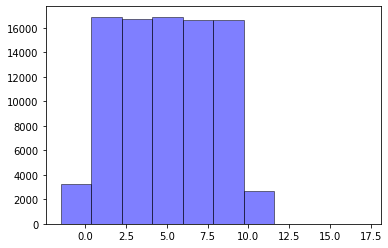

In [703]:
#histogram of origianl score distribution among the 10 categories
x = df3['score']
num_bins = 10
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5, ec='black')
plt.show()

In [704]:
# sort original dataframe by descending scores
df3_sorted = df3.sort_values(by=['score', 'id'], ascending=False)

####  RE-SCORING:
Also in this case we use an empirical distribution value for a = 1.1

In [705]:
#create Zipfian (Zipf) distribution. 
a = 1.1
zipf_dist = np.random.zipf(a,df3.shape[0])

In [706]:
#sort Zipf distribution  
zipf_dist[::-1].sort()

#normalize values between 0-10 to fulfill [GOAL1]
zipf_dist_norm = ((zipf_dist-min(zipf_dist))/(max(zipf_dist)-min(zipf_dist))) * 10

# add normalized scores as a new column to the dataframe 
df3_sorted['zipf score'] = zipf_dist_norm

In [707]:
# mix score = original_score * weight_orig + zipf_score * weight_zipf
weight_zipf = 0.9
weight_orig = 0.1
mix_score = df3_sorted['score']*weight_orig + df3_sorted['zipf score']*weight_zipf
df3_sorted['mix score'] = np.where(df3_sorted['score'] > 10, 10, mix_score)

In [708]:
df3_sorted.head(10)

,id,score,zipf score,mix score
68619,T__016102,17.173670,10.000000,10.000000
52214,T__016633,9.999817,9.987275,9.988530
50251,T__061134,9.999769,9.976716,9.979021
21636,T__025466,9.999729,9.973480,9.976105
33343,T__029356,9.999644,9.946528,9.951840
37128,T__080604,9.999448,9.931414,9.938218
57485,T__082311,9.999048,9.908920,9.917933
83158,T__066622,9.998935,9.906496,9.915740
30250,T__016396,9.998898,9.899583,9.909514
64477,T__065245,9.998880,9.895600,9.905928


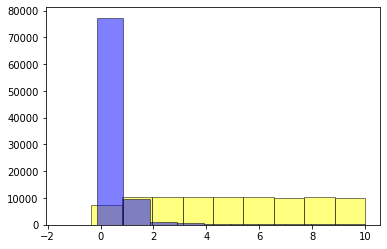

In [709]:
#histogram of the Zipf score distribution among the 10 categories
x = df3['score']
num_bins = 10
plt.hist(x[x<=10], num_bins, facecolor='yellow', alpha=0.5, ec='black')


x = df3_sorted['mix score']
num_bins = 10
n, bins, patches = plt.hist(x[x<=10], num_bins, facecolor='blue', alpha=0.5, ec='black')
plt.show()

In [710]:
# number of elements with each score interval 
print(n)

[77310.  9545.  1008.   536.   366.   260.   241.   189.   145.   118.]


In [711]:
#percentage of elements with scores between 9 and 10: ~ 0.12% [GOAL3] is satisfied!
n[-1]/df1.shape[0]*100

0.12840462691926832

## PART 2 - Second data set [Power Function]

####  DATA PRE-ANALYSIS:

The second data set has duplicate POI ids, which I dropped before performing the analysis - I did not check if the higher or the lower score was kept for each duplicate, which could be done, if necessary

In [712]:
# basic statistical info of the distribution
df2.describe()

,score
count,154944.000000
mean,2.543298
std,1.104681
min,0.075584
25%,1.683594
50%,2.686089
75%,3.079849
max,9.978895


In [713]:
# dropping ALL duplicte values 
df2 = df2.drop_duplicates(subset='id')

In [714]:
# Uniqueness test 'score': several scores are repeated. Since we create the new scores based in an external funtion 
# AND in the original scores, this proportion will not be kept.
df2['score'].value_counts().head(10)

1.517741    1343
2.237741     879
1.537905     565
1.637741     524
2.257905     475
2.117741     386
1.877741     297
1.406766     292
2.272559     285
2.377905     285
Name: score, dtype: int64

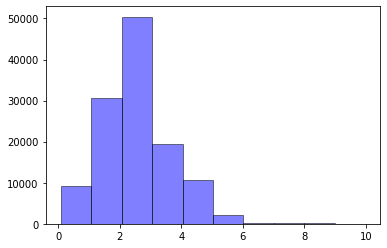

In [715]:
#histogram of origianl score distribution among the 10 categories
x = df2['score']
num_bins = 10
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5, ec='black')
plt.show()

In [716]:
# sort original dataframe by descending scores. 
df2_sorted = df2.sort_values(by=['score', 'id'], ascending=False)

####  RE-SCORING:
In an first approach I tried to meet the goals by using the Pareto power function, but unfortunalety I could not tune it in a satisfactory way. Instead of using it I decided for the power function, which is a the inverse of the Pareto distribution. 

I found satisfatory resultss by using a parameter of 0.1. For this function the only necessary normalization was multiplying the distribution x 10, as the generated values are between 0 and 1.

In [724]:
#create Power distribution. 
a = 0.1
power_dist = np.random.power(a,df2.shape[0])

In [725]:
#sort Zipf distribution  
power_dist[::-1].sort()

#the power function generates values between 0 and 1 - therefore we just need to multiply them by 10 to "normalize" them
power_dist_norm = power_dist * 10

df2_sorted['power score'] = power_dist_norm

In [726]:
# mix score = original_score * weight_orig + power_score * weight_power
# For this function I got better results but increasing the share of the original scores in the average (0.65-0.35) - 
# There is, of course, enough room for improvements here!

weight_power = 0.65
weight_orig = 0.35
mix_score = df2_sorted['score']*weight_orig + df2_sorted['power score']*weight_power
df2_sorted['mix score'] = np.where(df2_sorted['power score'] <= 10, mix_score, 10)

In [727]:
df2_sorted.head(10)

,id,score,power score,mix score
43633,T__090ce1e666ea,9.978895,9.998317,9.991519
25320,T__2174d75627c1,9.919893,9.994355,9.968293
65090,T__85442a13f9b1,9.741483,9.993884,9.905544
15590,T__4e2dc10ba3e0,9.725527,9.992934,9.899342
138982,T__a50467a12849,9.658986,9.992670,9.875881
46281,T__08161a7d68cf,9.638736,9.990514,9.867391
23814,T__a6a9d3987005,9.564022,9.990415,9.841178
131141,T__064a9f565efc,9.482713,9.990222,9.812594
123072,T__450bc550c54e,9.468666,9.987823,9.806118
22398,T__7346d3b3c938,9.454223,9.986260,9.800047


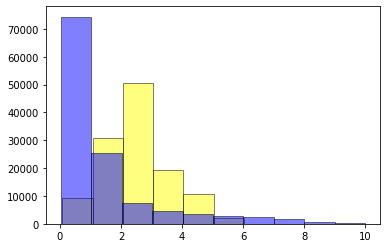

In [728]:
#histogram of the Zipf score distribution among the 10 categories
x = df2_sorted['score']
num_bins = 10
plt.hist(x, num_bins, facecolor='yellow', alpha=0.5, ec='black')

x = df2_sorted['mix score']
num_bins = 10
n, bins, patches = plt.hist(x[x<=10], num_bins, facecolor='blue', alpha=0.5, ec='black')
plt.show()

In [729]:
print(n)

[74374. 25255.  7347.  4676.  3476.  2680.  2266.  1831.   611.   173.]


In [730]:
#percentage of elements with scores between 9 and 10: ~ 0.18% [GOAL3] is satisfied!
n[-1]/df1.shape[0]*100

0.18825424116130016

##  Conclusion:
By using the approach of creating a new (normalized) distribution with the Zipf function and then "weight-averaging" this  new values and the original scores, I managed to satisfy [GOAL1] and [GOAL3]. The [GOAL2] was, is my opinion, only partially fulfilled using Zipf, as the the massive majority of POIs is between 0 and 1, even though THERE WERE more POIs with score between k-1 and k than between k and k+1 for all k in [1..9]. Results for the first data set and the third data set are quit similar.

The Power Function used in Part2 led to better results - the "drop" in the amount of POIs for two consecutive intervals (0-1, 1-2...) is not so extreme. Both [GOAL1], [GOAL2] and [GOAL3] are met.

##  TO-DOs:

* Clean the code and encapsule repetitive scripts in more general functions.

* Use the third data set to validate also Part2 and also test with other data sets [GOAL 4]

* Find better ways to tune the parameter "a" for Zipf & Power Functions

* Find an optimum for the weight average (original and generated distributions) 

